<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Константая-(baseline)-модель" data-toc-modified-id="Константая-(baseline)-модель-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Константая (baseline) модель</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес-(алгоритм-бэггинга)" data-toc-modified-id="Случайный-лес-(алгоритм-бэггинга)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Случайный лес (алгоритм бэггинга)</a></span></li><li><span><a href="#Построение-модели-градиентного-бустинга-с-помощью-LightGBM" data-toc-modified-id="Построение-модели-градиентного-бустинга-с-помощью-LightGBM-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Построение модели градиентного бустинга с помощью LightGBM</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Оценка-качества-выбранной-модели-на-тестовой-выборке" data-toc-modified-id="Оценка-качества-выбранной-модели-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Оценка качества выбранной модели на тестовой выборке</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Прогнозирование стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для прогнозирования рыночной стоимости автомобиля.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [2]:
import pandas as pd
# отображение ВСЕХ столбцов
pd.options.display.max_columns = None

import numpy as np
import matplotlib.pyplot as plt

# модуль для разделения выборки на части и оценки качетсва моделей кросс-валидоцией
from sklearn.model_selection import train_test_split, cross_val_score

# пайплайны позволяют объединять различные шаги препроцессинга и этап обучения модели
from sklearn.pipeline import Pipeline
# заполнение пропусков
from sklearn.impute import SimpleImputer
# кодирование категориальных признаков
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

# модуль для масштабирования числовых признаков
from sklearn.preprocessing import StandardScaler

# алгорит для обучения baseline моделей
from sklearn.dummy import DummyRegressor

# импортируем алгоритм линейной регрессии
from sklearn.linear_model import LinearRegression

# импортируем алгоритм случайного леса
from sklearn.ensemble import RandomForestRegressor

# импортируем модель градиентного бустинга
from lightgbm import LGBMRegressor

# импортируем модуль подбора гиперпараметров модели
from sklearn.model_selection import GridSearchCV

# функции метрик
from sklearn.metrics import mean_squared_error as mse

from datetime import datetime

# игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/datasets/autos.csv')
# display(df.head())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Выводы** 
1. Признаки 'DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen' бесполезны для целей прогнозирования. Их можно удалить.
2. Ряд столбцов содержат пропуски. Их нужно заполнить.
3. Числовые признаки перед обучением модели линейной регрессии необходимо привести к одному масштабу.

In [4]:
# Удаляем ненужные столбцы
df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

# Создадим списки категориальных и числовых признаков
cat_features = df.select_dtypes(include='object').columns
num_features = df.select_dtypes(exclude='object').columns

In [5]:
# Определим количество пропусков в столбцах с категориальными и числовыми признаками
display(
        df[cat_features].isna().sum(),
        df[num_features].isna().sum()
        )
        

VehicleType    37490
Gearbox        19833
Model          19705
FuelType       32895
Brand              0
NotRepaired    71154
dtype: int64

Price                0
RegistrationYear     0
Power                0
Kilometer            0
RegistrationMonth    0
dtype: int64

**Вывод**. Пропуски есть только в столбцах с категориальными признаками. Их можно заполнить значением 'unknown'.

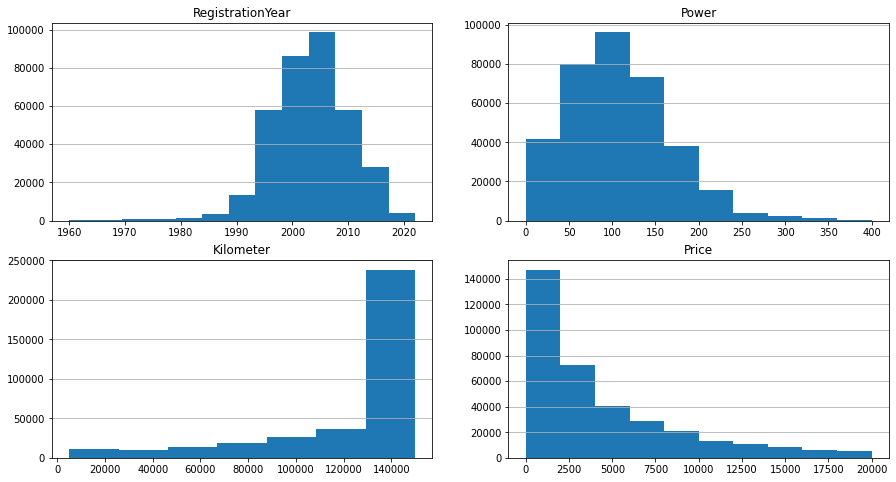

In [6]:
# Построим гистограммы распределения значений числовых признаков. 
# Проверим наличие редких и аномальных значений.

fig, ax = plt.subplots(2, 2, figsize=(15, 8))

ax[0, 0].hist(df['RegistrationYear'], bins=13, range=(1960, 2022))
ax[0, 0].set_title('RegistrationYear')
ax[0, 0].grid(axis='y')

ax[0, 1].hist(df['Power'], bins=10, range=(0, 400))
ax[0, 1].set_title('Power')
ax[0, 1].grid(axis='y')

ax[1, 0].hist(df['Kilometer'], bins=7)
ax[1, 0].set_title('Kilometer')
ax[1, 0].grid(axis='y')

ax[1, 1].hist(df['Price'], bins=10)
ax[1, 1].set_title('Price')
ax[1, 1].grid(axis='y')

plt.show()

In [7]:
# Проверим наличие аномальных значений в столбце с месяцами регистрации
df['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

**Выводы**. В столбцах 'RegistrationYear', 'RegistrationMonth', 'Power' обнаружены редкие и аномальные значения. Их необходимо отбросить.

In [8]:
df_filtered = df.loc[(df['RegistrationYear'] >= 1960) &
                     (df['RegistrationYear'] <= 2022) &
                     (df['RegistrationMonth'] > 0) &
                     (df['Power'] <= 400)]

display(
        df.shape,
        df_filtered.shape
        )

(354369, 11)

(316103, 11)

In [9]:
# Отделим целевой признак от остальных.
X = df_filtered.drop(['Price'], axis=1)
y = df_filtered['Price']

# Отделим 20% данных для тестовой выборки.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=12345)

display(X_train.shape, X_test.shape)

(252882, 10)

(63221, 10)

In [10]:
# Исключим из списка числовых обучающих признаков целевой
num_features = num_features[1:]

# Создадим трансформер признаков для предобработки данных
numeric_transformer = Pipeline(steps=[ 
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Используем ColumnTransformer для трансформации признаков 
preprocessor = ColumnTransformer(transformers=[ 
    ('num', numeric_transformer, num_features), 
    ('cat', categorical_transformer, cat_features)]) 

X_train_transform = preprocessor.fit_transform(X_train)
X_test_transform = preprocessor.transform(X_test)

In [11]:
display(
        X_train_transform,
        X_test_transform
        )

<252882x317 sparse matrix of type '<class 'numpy.float64'>'
	with 2528820 stored elements in Compressed Sparse Row format>

<63221x317 sparse matrix of type '<class 'numpy.float64'>'
	with 632210 stored elements in Compressed Sparse Row format>

In [157]:
del df
del df_filtered
del X_train
del X_test

## Обучение моделей

In [158]:
# Создадим нулевой датафрейм, куда будут записаваться данные о времени обучения и качестве прогнозирования

cols_results = ['time_min', 'RMSE']
index_results = ['baseline_model', 'linear_regression', 'random_forest', 'model_GBM']

df_results = pd.DataFrame(data=0 , columns=cols_results, index=index_results)

### Константая (baseline) модель

In [159]:
# Время начала обучения модели
time_begin = datetime.now()

# Инициализируем модель
dummy_reg = DummyRegressor(strategy="median")

# Обучаем модель на тренировочной выборке
dummy_reg.fit(X_train_transform, y_train)

# Оценим качество и время обучения модели кросс-валидацией
RMSE_train = cross_val_score(dummy_reg, 
                             X_train_transform, 
                             y_train, 
                             scoring='neg_mean_squared_error', 
                             cv=3)

# Время окончания обучения модели
time_final = datetime.now()

# Продолжительность обучения в секундах
time_diff = time_final - time_begin

# Запишем данные в таблицу
df_results.iloc[0, 0] = time_diff.total_seconds() / 60
df_results.iloc[0, 1] = round(abs(RMSE_train.mean())**0.5)

print("Затраты времени на обучение, мин.", 
      df_results.iloc[0, 0])

# Оценим качество модели 
print("Оценка RMSE константной модели кросс-валидацией:", 
       df_results.iloc[0, 1])

Затраты времени на обучение, мин. 0.0008510166666666667
Оценка RMSE константной модели кросс-валидацией: 4882


### Линейная регрессия

In [160]:
# Время начала обучения модели
time_begin = datetime.now()

# Инициализируем модель
lin_reg = LinearRegression()

# Обучаем модель на тренировочной выборке
lin_reg.fit(X_train_transform, y_train)

# Оценим качество и время обучения модели кросс-валидацией
RMSE_train = cross_val_score(lin_reg, 
                            X_train_transform, 
                            y_train, 
                            scoring='neg_mean_squared_error', 
                            cv=3)

# Время окончания обучения модели
time_final = datetime.now()

# Продолжительность обучения в секундах
time_diff = time_final - time_begin

# Запишем данные в таблицу
df_results.iloc[1, 0] = time_diff.total_seconds() / 60
df_results.iloc[1, 1] = round(abs(RMSE_train.mean())**0.5)

print("Затраты времени на обучение, мин.", 
      df_results.iloc[1, 0])

# Оценим качество модели 
print("Оценка RMSE модели линейной регрессии кросс-валидацией:", 
       df_results.iloc[1, 1])

Затраты времени на обучение, мин. 2.2241659
Оценка RMSE модели линейной регрессии кросс-валидацией: 2698


### Случайный лес (алгоритм бэггинга)

In [161]:
# Время начала обучения модели
time_begin = datetime.now()

# Варьируемые гиперпараметры:
# n_estimators – число деревьев;
# max_depth – глубина дерева.

hyperparameters = { 'n_estimators': range (80, 101, 10) }


# Инициализируем модель случайного леса
random_forest = RandomForestRegressor(random_state=12345, max_depth=5)

# Запускаем обучение модели случайного леса с использованием кросс-валидации
grid = GridSearchCV(random_forest, hyperparameters, scoring='neg_mean_squared_error', cv=3)

grid.fit(X_train_transform, y_train)

# Время окончания обучения модели
time_final = datetime.now()

# Продолжительность обучения в секундах
time_diff = time_final - time_begin

# Запишем данные в таблицу
df_results.iloc[2, 0] = time_diff.total_seconds() / 60
df_results.iloc[2, 1] = round(abs(grid.best_score_)**0.5)

print("Затраты времени на обучение, мин.", 
      df_results.iloc[2, 0])

# Оценим качество модели 
print("Оценка RMSE лучшей модели случайного леса кросс-валидацией:", 
       df_results.iloc[2, 1])

# Определим лучшие гиперпараметры модели
print(f"Гиперпараметры лучшей модели случайного леса: ", 
      grid.best_params_)

Затраты времени на обучение, мин. 5.8489347
Оценка RMSE лучшей модели случайного леса кросс-валидацией: 2492
Гиперпараметры лучшей модели случайного леса:  {'n_estimators': 100}


### Построение модели градиентного бустинга с помощью LightGBM

In [162]:
# Время начала обучения модели
time_begin = datetime.now()

# Варьируемые гиперпараметры:
# n_estimators – число деревьев;
# max_depth – глубина дерева.

hyperparameters = { 'n_estimators': range (80, 101, 10) }

# Инициализируем модель градиентного бустинга
model_boosting = LGBMRegressor(random_state=12345, max_depth=5)

# Запускаем обучение модели градиентного бустинга с использованием кросс-валидации
grid = GridSearchCV(model_boosting, hyperparameters, scoring='neg_mean_squared_error', cv=3)

grid.fit(X_train_transform, y_train)

# Время окончания обучения модели
time_final = datetime.now()

# Продолжительность обучения в секундах
time_diff = time_final - time_begin

# Запишем данные в таблицу
df_results.iloc[3, 0] = time_diff.total_seconds() / 60
df_results.iloc[3, 1] = round(abs(grid.best_score_)**0.5)

print("Затраты времени на обучение, мин.", 
      df_results.iloc[3, 0])

# Оценим качество модели 
print("Оценка RMSE лучшей модели градиентного бустинга кросс-валидацией:", 
       df_results.iloc[3, 1])

# Определим лучшие гиперпараметры модели
print(f"Гиперпараметры лучшей модели градиентного бустинга: ", 
      grid.best_params_)

Затраты времени на обучение, мин. 0.5909005333333333
Оценка RMSE лучшей модели градиентного бустинга кросс-валидацией: 1878
Гиперпараметры лучшей модели градиентного бустинга:  {'n_estimators': 100}


## Анализ моделей

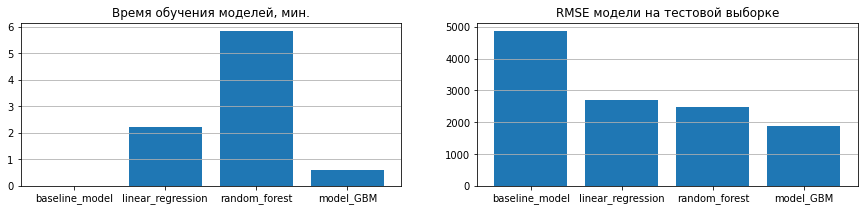

In [163]:
# Построим столбчатые диаграммы
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

ax[0].bar(df_results.index, 
           df_results['time_min'])
ax[0].set_title('Время обучения моделей, мин.')
ax[0].grid(axis='y')

ax[1].bar(df_results.index, 
           df_results['RMSE'])
ax[1].set_title('RMSE модели на тестовой выборке')
ax[1].grid(axis='y')

plt.show()

**Вывод**: наилучшие результаты по соотношению производительность/качество показала модель LightGBM.

## Оценка качества выбранной модели на тестовой выборке

In [164]:
best_model_boosting = LGBMRegressor(random_state=12345, n_estimators=100, max_depth=5) 

# Обучаем модель на тренировочной выборке
best_model_boosting.fit(X_train_transform, y_train)

# Прогнозируем целевой признак 
predictions = best_model_boosting.predict(X_test_transform)

print("RMSE лучшей модели градиентного бустинга на тестовой выборке:", 
      mse(y_test, predictions, squared=False).round(0))

RMSE лучшей модели градиентного бустинга на тестовой выборке: 1875.0


**Вывод**: качество прогнозирования на тестовой и обучающей выборках примерно одинаковое.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей